<a href="https://colab.research.google.com/github/SasidharReddyV/Projects/blob/main/Sim_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import hashlib
import hmac
import base64
import requests
import datetime
import csv
import time
import json
import pandas as pd




class API_TRADING:
    def __init__(self, api_key, api_secret,api_url,sim = False):
        self.api_key = api_key
        self.api_secret = api_secret
        self.api_url = api_url
        self.setup_request_types()
        self.sim_active=sim
        self.curr_idx = 0
        self.curr_df = None
        self.orders= {}




    def setup_request_types(self):
        self.orderbook_url= os.path.join(self.api_url, "l2orderbook")
        self.historical_candles_url= os.path.join(self.api_url, "history/candles")



    def generate_signature(self,message):
        message = bytes(message, 'utf-8')
        secret = bytes(self.api_secret, 'utf-8')
        hash = hmac.new(secret, message, hashlib.sha256)
        return hash.hexdigest()

    def get_curr_timestamp(self):
        """
        returns the Unix timestamp for the current time in UTC timezone

        """
        d = datetime.datetime.utcnow()
        epoch = datetime.datetime(1970,1,1)
        return str(int((d - epoch).total_seconds())*1) #1000 to get in millis

    def convert_date_to_timestamp(self,_date):
        """
        returns the Unix timestamp for a specific date in the format 'YYYYMMDD'

        """
        specific_date = datetime.datetime.strptime(_date, '%Y%m%d')
        epoch = datetime.datetime(1970, 1, 1)


    def convert_date_time_to_timestamp(self,_datetime):
        """
        returns the Unix timestamp for a specific UTC date-time in the format 'YYYYMMDD-H:M:S'

        """
        specific_date = datetime.datetime.strptime(_datetime, '%Y%m%d-%H:%M:%S')
        epoch = datetime.datetime(1970, 1, 1)
        return str(int((specific_date - epoch).total_seconds()))

    def convert_timestamp_to_date_time(self,timestamp):
        """
        returns the UTC date-time in the format 'YYYYMMDD-H:M:S' from a Unix timestamp.
        """
        epoch = datetime.datetime(1970, 1, 1)
        specific_date = epoch + datetime.timedelta(seconds=int(timestamp))
        return specific_date.strftime('%Y%m%d-%H:%M:%S')

    def place_limit_ord(self,price,qty,side):
        timestamp = self.get_curr_timestamp()
        params = {
              "product_symbol": "BTCUSD",
              "limit_price": price,
              "size": qty,
              "side": side,
              "order_type": "limit_order",
              "post_only": False,
              "client_order_id": "1"
            }
        method = 'POST'
        path = '/v2/orders'
        query_string = ''
        payload = json.dumps(params)
        signature_data = method + timestamp + path + query_string + payload
        signature = self.generate_signature(signature_data)
        headers = {
              'Content-Type': 'application/json',
              'Accept': 'application/json',
              'api-key': MOM_API_KEY,
              'signature': signature,
              'timestamp': timestamp
              }


        r = requests.post(f"{delta_api_url}/orders", json= params, headers = headers)
        return r.json()

    def place_market_ord(self,price,qty,side,client_order_id):
        if(client_order_id in self.orders and len(self.orders[client_order_id])==1):
            prev_entry,prev_qty = self.orders[client_order_id].pop()
            if(side=='buy'):
                return {'result': {'meta_data': {'pnl': ((prev_entry*1.00005)-(price*0.9995))*prev_qty}}}
            else:
                return {'result': {'meta_data': {'pnl': ((price*1.00005)-(prev_entry*0.9995))*prev_qty}}}
        else:
            self.orders[client_order_id] = [[price,qty]]





    def place_cancel_ord(self,exch_ord_id, client_ord_id):
        timestamp = self.get_curr_timestamp()
        params = {
              "product_symbol": "BTCUSD",
              "id":exch_ord_id,
              "client_order_id": str(client_ord_id)
              }
        method = 'DELETE'
        path = '/v2/orders'
        query_string = ''
        payload = json.dumps(params)
        signature_data = method + timestamp + path + query_string + payload
        signature = self.generate_signature(signature_data)
        headers = {
              'Content-Type': 'application/json',
              'Accept': 'application/json',
              'api-key': MOM_API_KEY,
              'signature': signature,
              'timestamp': timestamp
              }

        r = requests.delete(f"{delta_api_url}/orders", json=params, headers = headers)
        return r.json()



    def place_modify_ord(self,exch_ord_id,new_price, new_qty):
        timestamp = self.get_curr_timestamp()
        params = {
              "product_symbol": "BTCUSD",
              "limit_price": new_price,
              "size": new_qty,
              "id": exch_ord_id #exch id is int client is string
            }
        method = 'PUT'
        path = '/v2/orders'
        query_string = ''
        payload = json.dumps(params)
        signature_data = method + timestamp + path + query_string + payload
        signature = self.generate_signature(signature_data)
        headers = {
              'Content-Type': 'application/json',
              'Accept': 'application/json',
              'api-key': MOM_API_KEY,
              'signature': signature,
              'timestamp': timestamp
              }

        r = requests.put(f"{delta_api_url}/orders", json= params, headers = headers)
        return r.json()




    def place_cancel_all_ords(self):
        headers = {
              'Content-Type': 'application/json',
              'Accept': 'application/json',
              'api-key': MOM_API_KEY,
              'signature': '****',
              'timestamp': '****'
              }
        params = {
          "product_symbol": "BTCUSD",
          "contract_types": "perpetual_futures",
          "cancel_limit_orders": True,
          "cancel_stop_orders": True,
          "cancel_reduce_only_orders": True
                }
        r = requests.delete(f"{delta_api_url}/orders/all", json=params, headers = headers)
        return r.json()


    def get_data(self,symbol,candle_interval, candle_count): #candle_interval in minutes
        if(self.curr_df.shape[0]<=self.curr_idx):
          self.sim_active = False
          return False
        return_df=  self.curr_df.iloc[self.curr_idx-int(candle_count):self.curr_idx + 1]
        self.curr_idx += 1
        return return_df



    def get_ltp(self,symbol):
        headers = {
                    'Accept': 'application/json'
                  }
        r = requests.get(f"https://api.india.delta.exchange/v2/trades/{symbol}", headers = headers)
        return r.json()

    def get_orderbook(self,symbol):
        if(self.curr_df.shape[0]<=self.curr_idx):
          self.sim_active = False
          return False
        curr_row= self.curr_df.iloc[self.curr_idx]
        high,low= curr_row['high'],curr_row['low']
        return {'high':high, 'low': low}



In [2]:
import numpy as np
from scipy.stats import norm

class Strategy_MOM:
    def __init__(self,API, symbol,h, mult,risk_points, target_percentage,thresh,slope_length,window,percentle,prev_swing,look_back,client_order_id ):
        self.symbol = symbol
        self.API = API
        #strat params
        self.h = h
        self.mult = mult
        self.risk_points = risk_points
        self.target_percentage = target_percentage
        self.thresh = thresh
        self.slope_length = slope_length
        self.window = window
        self.percentle = percentle
        self.prev_swing = prev_swing
        self.look_back = look_back
        self.cooloff = False

#        self.position_taken = False
        self.side = None
        self.client_order_id = client_order_id
        self.exchange_order_id = None
        self.df = None


        self.adjusted_trailing_stop = None
        self.position_size = 0
        self.entry_price = 0
        self.initial_stop = None
        self.final_target_price = None
        print("strat initialised" )

    def calculate_atr(self):
        high_low = self.df['high'] - self.df['low']
        high_close = np.abs(self.df['high'] - self.df['close'].shift(1))
        low_close = np.abs(self.df['low'] - self.df['close'].shift(1))
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = true_range.rolling(window=self.window).mean()
        self.df['atr'] = atr
        return

    def gauss(self,x):
        return norm.pdf(x, scale= self.h)

    def new_data_cb(self,data):
        if(self.position_size !=0 or self.cooloff == True):
            self.cooloff=False
            return
        self.df = data
        n = len(self.df)
        out = np.zeros(n)
        gaussian_weights = np.array([self.gauss(i) for i in range(self.look_back)])
        src = self.df['close']
        gaussian_weights /= gaussian_weights.sum()
        for i in range(self.look_back, n):
            out[i] = np.dot(gaussian_weights, src.values[i-self.look_back+1:i+1][::-1])
        out = pd.Series(out, index=src.index)
        mae = pd.Series(np.abs(src - out)).rolling(window=499).mean() * self.mult
        upper = out + mae
        lower = out - mae
        self.df['Upper'] = upper
        self.df['Lower'] = lower
        self.df['Slope'] = (self.df['Upper'] - self.df['Upper'].shift(self.slope_length)) / self.slope_length
        self.calculate_atr()
        self.df['Buy_Condition'] = (
            (self.df['low'] < self.df['Upper']) &
            (self.df['close'] > self.df['Upper']) &
            (self.df['Slope'] > self.thresh * self.df['close']) &
            (self.df['low'].rolling(window=self.prev_swing).min() < self.df['Lower']) &
            (self.df['atr'] > self.df['atr'].rolling(window=self.window ).apply(lambda x: np.percentile(x, self.percentle), raw=True))
            )

        self.df['Sell_Condition'] = (
            (self.df['open'] > self.df['Lower']) &
            (self.df['close'] < self.df['Lower']) &
            (self.df['Slope'] < -self.thresh * self.df['close']) &
            (self.df['high'].rolling(window=self.prev_swing).max() > data['Upper']) &
            (self.df['atr'] > self.df['atr'].rolling(window=self.window ).apply(lambda x: np.percentile(x, self.percentle),raw=True))
            )
        recent_data_point = self.df.iloc[-1]
        # print(recent_data_point) #delete_later
        buy_condition = recent_data_point['Buy_Condition']
        sell_condition = recent_data_point['Sell_Condition']

        if(buy_condition):
            self.entry_price = recent_data_point['close']
            self.initial_stop = self.entry_price - recent_data_point['low']  # Stop-loss
            self.final_target_price = self.entry_price * (1 + self.target_percentage / 100)  # Target price for long
            self.position_size = max(1, int((self.risk_points * recent_data_point['close']/100) / self.initial_stop))
            #self.position_size = 2500//self.risk_points
            # self.position_size = 1
            self.adjusted_trailing_stop = max(self.entry_price - self.initial_stop, recent_data_point['Lower'])  # Set initial trailing stop
            self.side = 'buy'
            response = self.API.place_market_ord(self.entry_price,self.position_size,self.side,self.client_order_id)
            #self.entry_price = float(response['result']['average_fill_price'])
            #self.exchange_order_id = int(response['result']['id'])

        elif(sell_condition):
            self.entry_price = recent_data_point['close']
            self.initial_stop = recent_data_point['high'] - self.entry_price  # Stop-loss for short
            self.final_target_price = self.entry_price * (1 - self.target_percentage / 100)  # Target price for short
            self.position_size = max(1, int((self.risk_points * recent_data_point['close']/100) / self.initial_stop))
            # self.position_size = 1
            self.adjusted_trailing_stop = min(self.entry_price + self.initial_stop, recent_data_point['Upper'])  # Set initial trailing stop
            self.side = 'sell'
            response= self.API.place_market_ord(self.entry_price, self.position_size,self.side,self.client_order_id)
            #self.entry_price = float(response['result']['average_fill_price'])
            #self.exchange_order_id = int(response['result']['id'])
        return


    def new_orderbook_cb(self,book):
        if(self.position_size==0):
            return
        print(f"entry price:{self.entry_price}, ts:{self.adjusted_trailing_stop}, tgt:{self.final_target_price}")
        if(self.side=='buy' and (book['low']<=self.adjusted_trailing_stop or self.final_target_price<=book['high'])):
            price= 0
            if(book['low']<=self.adjusted_trailing_stop):
                price = book['low']
            else:
                price = book['high']
            self.side='sell'
            response = self.API.place_market_ord(price,self.position_size,self.side,self.client_order_id)
            self.position_size =0
            # print(f"pnl:{response['result']['meta_data']['pnl']}")
            return response['result']['meta_data']['pnl']


        elif(self.side=='sell' and (book['high']>=self.adjusted_trailing_stop or self.final_target_price>=book['low'])):
            price = 0
            if(book['high']>=self.adjusted_trailing_stop):
                price = book['high']
            else:
                price = book['low']
            self.side='buy'
            response = self.API.place_market_ord(price,self.position_size,self.side,self.client_order_id)
            self.position_size =0
            # print(f"pnl:{response['result']['meta_data']['pnl']}")
            return response['result']['meta_data']['pnl']
        return

In [3]:
import json

import time
import pandas as pd


class Strat_Base:

    def __init__(self,symbol):
        self.regd_strats = []
        self.API = None
        self.symbol = symbol
        self.pnl = {}


    def reg_api(self,sim=False ):
        self.API = API_TRADING('0','0','0',sim)
        print("trading api started!!!")

    def reg_strat(self, new_strat):
        self.regd_strats.append(new_strat)
        self.pnl[new_strat.client_order_id] = []
        print(f"registered stategy{len(self.regd_strats)}")


    def fetch_data(self,candle_interval,candle_count):
        return self.API.get_data(self.symbol,candle_interval, candle_count)


    def fetch_book(self):
        return self.API.get_orderbook(self.symbol)

    def get_next_ts(self, interval): #this returns int
        curr_ts = self.API.get_curr_timestamp()
        interval_in_sec  = interval*60
        next_interval_in_ts = ((int(curr_ts)//interval_in_sec) + 1) * interval_in_sec
        return next_interval_in_ts

    def feed_data(self,data):
        for strat in self.regd_strats:
            strat.new_data_cb(data)

    def feed_orderbook(self,data):
        for strat in self.regd_strats:
            pnl= strat.new_orderbook_cb(data)
            if(pnl is not None):
                self.pnl[strat.client_order_id].append(pnl)



def main():
    strategy_base = Strat_Base('BTCUSD')
    time.sleep(0.1)
    strategy_base.reg_api(sim=True)
    # strat_1 = Strategy_MOM(strategy_base.API, 'BTCUSD', 5, 1.0, 1, 1, 1/4750, 1, 7, 70, 12, 500, 1000000)
    strat_1 = Strategy_MOM(strategy_base.API, 'BTCUSD', 15, 3.0, 1.5, 7, 1/4750, 1, 7, 70, 12, 500, 1000000)
    strat_2 = Strategy_MOM(strategy_base.API, 'BTCUSD', 15, 3.0, 1.5, 7, 1/4750, 1, 11, 70, 12, 500, 5000000)
    strategy_base.reg_strat(strat_1)
    strategy_base.reg_strat(strat_2)
    strategy_base.API.curr_df = pd.read_csv('/content/output.csv')
    strategy_base.API.curr_df['time'] = pd.to_datetime(strategy_base.API.curr_df['time'], unit='s')
    strategy_base.API.curr_idx = 1000

    _15_min_in_s = 15*60
    curr_ts = strategy_base.API.get_curr_timestamp()
    next_ts = strategy_base.get_next_ts(15)

    prev_ts = None

    """ -----only for live -----

    while(next_ts - int(curr_ts) > 15 ):
        curr_ts = strategy_base.API.get_curr_timestamp()
        if(curr_ts!= prev_ts):
            print(f"firing up the strategy in : {next_ts - int(curr_ts)}s")
            prev_ts = curr_ts
    start = time.time()

    """

    start = time.time()
    total_time = 0
    total_count = 0
    print("starting data replay 3..2..1..!!")
    while(strategy_base.API.sim_active):
        curr_book= strategy_base.fetch_book()
        if(curr_book is False):
          print("data replay finished!!")
          continue
        strategy_base.feed_orderbook(curr_book)
        curr_data = strategy_base.fetch_data(15,1000)

        curr_df = pd.DataFrame(curr_data)
        curr_df_reversed = curr_df[::-1].reset_index(drop=True)
        strategy_base.feed_data(curr_df_reversed)


        total_time+= time.time()-start
        total_count+= 1
        start = time.time()
        print(f"current idx is: {strategy_base.API.curr_idx}")
    print(f"average sim time on {total_count} loops is {total_time/total_count}")
    return strategy_base


base = main()

Streaming output truncated to the last 5000 lines.
current idx is: 4912
current idx is: 4913
current idx is: 4914
current idx is: 4915
current idx is: 4916
current idx is: 4917
current idx is: 4918
current idx is: 4919
current idx is: 4920
current idx is: 4921
current idx is: 4922
current idx is: 4923
current idx is: 4924
current idx is: 4925
current idx is: 4926
current idx is: 4927
current idx is: 4928
current idx is: 4929
current idx is: 4930
current idx is: 4931
current idx is: 4932
current idx is: 4933
current idx is: 4934
current idx is: 4935
current idx is: 4936
current idx is: 4937
current idx is: 4938
current idx is: 4939
current idx is: 4940
current idx is: 4941
current idx is: 4942
current idx is: 4943
current idx is: 4944
current idx is: 4945
current idx is: 4946
current idx is: 4947
current idx is: 4948
current idx is: 4949
current idx is: 4950
current idx is: 4951
current idx is: 4952
current idx is: 4953
current idx is: 4954
current idx is: 4955
current idx is: 4956
curr

In [4]:
base.pnl


{1000000: [np.float64(-9749.815474999996),
  np.float64(-1357.4728999999934),
  np.float64(-4020.5768249999965),
  np.float64(-11713.455199999997),
  np.float64(-5045.869849999988),
  np.float64(-867.991399999999),
  np.float64(-4932.325249999994),
  np.float64(-18921.93982499998),
  np.float64(-33424.59494999997),
  np.float64(-2458.5937999999733)],
 5000000: [np.float64(-9749.815474999996),
  np.float64(-58889.65774999997),
  np.float64(-1357.4728999999934),
  np.float64(-4020.5768249999965),
  np.float64(-11713.455199999997),
  np.float64(-5350.745674999998),
  np.float64(-5045.869849999988),
  np.float64(-1231.1922250000061),
  np.float64(-4932.325249999994),
  np.float64(-3473.5544999999984),
  np.float64(7792.2706000000035),
  np.float64(-653.8234499999962),
  np.float64(-7979.848249999981)]}

In [5]:
act_df = pd.read_csv('/content/output.csv')

In [6]:
import matplotlib.pyplot as plt

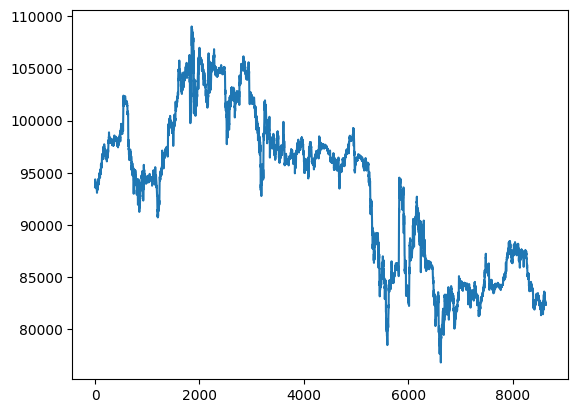

In [7]:
y = act_df['close']
x = range(len(y))
plt.plot(x,y)

In [8]:
{1000000: [np.float64(-9749.815474999996),
  np.float64(-1357.4728999999934),
  np.float64(-4020.5768249999965),
  np.float64(-11713.455199999997),
  np.float64(-5045.869849999988),
  np.float64(-867.991399999999),
  np.float64(-2466.162624999997),
  np.float64(-6307.313274999993),
  np.float64(-11141.53164999999),
  np.float64(-614.6484499999933)],
 5000000: [np.float64(-9749.815474999996),
  np.float64(-11777.931549999994),
  np.float64(-1357.4728999999934),
  np.float64(-4020.5768249999965),
  np.float64(-11713.455199999997),
  np.float64(-5350.745674999998),
  np.float64(-5045.869849999988),
  np.float64(-1231.1922250000061),
  np.float64(-2466.162624999997),
  np.float64(-1736.7772499999992),
  np.float64(7792.2706000000035),
  np.float64(-653.8234499999962),
  np.float64(-3989.9241249999905)]}

{1000000: [np.float64(-9749.815474999996),
  np.float64(-1357.4728999999934),
  np.float64(-4020.5768249999965),
  np.float64(-11713.455199999997),
  np.float64(-5045.869849999988),
  np.float64(-867.991399999999),
  np.float64(-2466.162624999997),
  np.float64(-6307.313274999993),
  np.float64(-11141.53164999999),
  np.float64(-614.6484499999933)],
 5000000: [np.float64(-9749.815474999996),
  np.float64(-11777.931549999994),
  np.float64(-1357.4728999999934),
  np.float64(-4020.5768249999965),
  np.float64(-11713.455199999997),
  np.float64(-5350.745674999998),
  np.float64(-5045.869849999988),
  np.float64(-1231.1922250000061),
  np.float64(-2466.162624999997),
  np.float64(-1736.7772499999992),
  np.float64(7792.2706000000035),
  np.float64(-653.8234499999962),
  np.float64(-3989.9241249999905)]}